In [1]:
import tensorflow as tf
tf.enable_eager_execution()

In [6]:
import matplotlib.pyplot as plt

In [55]:
filename = tf.constant('0df89aea.png')
image_string = tf.read_file(filename)
png = tf.image.decode_png(image_string)


In [56]:
get_alpha = lambda png: png[:,:,3]
alpha = get_alpha(png)
alpha.shape

TensorShape([Dimension(442), Dimension(822)])

In [57]:
def find_ones(alpha):
    ones = tf.not_equal(alpha, tf.constant(0, dtype=tf.uint8))
    where = tf.where(ones)
    return where
ones = find_ones(alpha)
lower_left = tf.reduce_min(ones, axis=0)
upper_right = tf.reduce_max(ones, axis=0)
offset = upper_right-lower_left
png_crop = tf.image.crop_to_bounding_box(png, lower_left[0], lower_left[1], offset[0], offset[1])

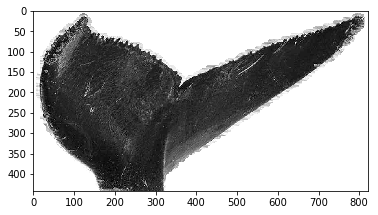

In [58]:
plt.imshow(png)

In [59]:
TARGET_WIDTH = 800
TARGET_HEIGHT = 400

max_dim = max(png_crop.shape)
max_target = max(TARGET_WIDTH, TARGET_HEIGHT)
max_max = max(max_dim, max_target)


In [52]:
def center_pad(image, target_width, target_height):
    # pads in such a way that the original image stays centered
    
    # first convert values to ints 
    image_height, image_width, _ = image.shape
    image_height = int(image_height)
    image_width = int(image_width)
    target_width = int(target_width)
    target_height = int(target_height)
    
    # calculate overall padding
    pad_height = target_height - image_height
    pad_width = target_width - image_width
    assert(pad_height >= 0)
    assert(pad_width >= 0)
    
    # now break it up into 2 steps
    pad_height1 = pad_height // 2
    pad_height2 = pad_height - pad_height1
    pad_width1 = pad_width // 2
    pad_width2 = pad_width - pad_width1
    
    # perform the padding with a rotate 180* between steps
    pad_image = tf.image.pad_to_bounding_box(image, 
                                             offset_height = pad_height1, 
                                             offset_width = pad_width1,
                                             target_height = image_height + pad_height1,
                                             target_width = image_width + pad_width1)
    pad_image = tf.image.rot90(pad_image, k=2) # 180*
    pad_image = tf.image.pad_to_bounding_box(pad_image, 
                                             offset_height = pad_height2, 
                                             offset_width = pad_width2,
                                             target_height = target_height,
                                             target_width = target_width)
    
    # and a final 180* to upright the image
    pad_image = tf.image.rot90(pad_image, k=2) # 180*
    
    return pad_image

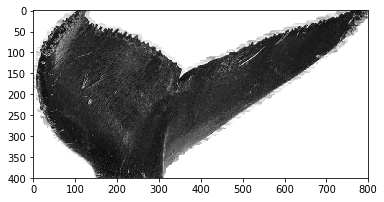

In [62]:
pad_png = center_pad(png_crop, target_width = max_max, target_height=max_max)
resize_png = tf.image.resize_images(pad_png, size=[800, 800])
final_png = tf.image.resize_image_with_crop_or_pad(resize_png, target_height = TARGET_HEIGHT, target_width=TARGET_WIDTH)
plt.imshow(tf.cast(final_png, dtype=tf.uint8))